# Dense Neural Network Poker Hand

INSTITUTO FEDERAL DE MINAS GERIAS Departamento de Engenharia e Computação

Professor: Ciniro Nametala

Aluno: Euler Gomes

Dataset: https://archive.ics.uci.edu/dataset/158/poker+hand

# 1. Ambient preparation

In [64]:
from IPython.display import display, HTML
from tensorflow.python.layers.core import dense

display(HTML("<style>.container {widht: 100% !important;}</style>"))

## 1.1. Import packages

In [65]:
import subprocess
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
import progressbar
import pygame

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

## 1.2. Export requirements.txt

In [66]:
def export_requirements():
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "freeze"],
                                capture_output=True,
                                text=True,
                                check=True)
        with open('requirements.txt', 'w') as f:
            f.write(result.stdout)
        print('requirements.txt file generated successfully.')
    except subprocess.CalledProcessError as e:
        print('error:', e)


export_requirements()

requirements.txt file generated successfully.


## 1.3. Gpu check

In [67]:
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow found GPUs: {len(gpus) > 0}")
print(f"TensorFlow GPU devices: {gpus}")

TensorFlow found GPUs: True
TensorFlow GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1.4. Experiment configuration

In [68]:
#create a new model
new_model = True

#export frame dataset
export_frames = False

# 2. Load dataset

In [69]:
#load dataset
data = pd.read_csv('data/poker_hand_dataset.csv')

#get columns names
col_names = data.columns.values.tolist()

x_names = data.columns[:-1].tolist()
y_names = data.columns[-1:].tolist()

data.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


# 3. Explore data

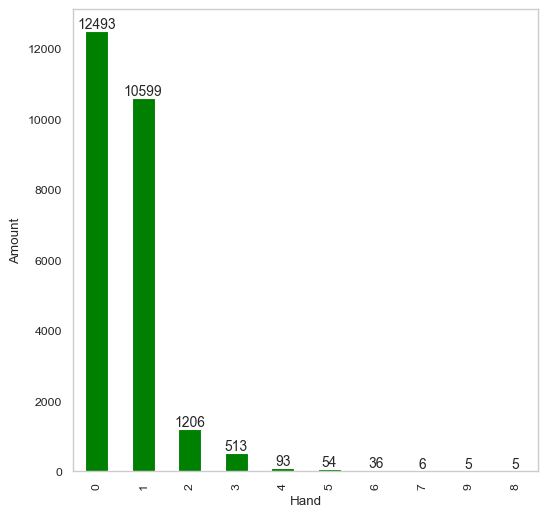

In [70]:
class_counts = data['class'].value_counts()  #count number of class

plt.figure(figsize=(6, 6))
class_counts.plot(kind="bar", color="green")
plt.xlabel("Hand")
plt.ylabel('Amount')
plt.grid(False)

for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

## 3.1. Summarization

In [71]:
def summarization(data):
    stats = []

    for column in col_names[0:9]:
        values = data[column]

        maximum = round(values.max(), 2)
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)

        stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Column', 'Max', 'Min', 'Mena', 'Median', 'Std']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)


summarization(data)

| Column   |   Max |   Min |   Mena |   Median |   Std |
|:---------|------:|------:|-------:|---------:|------:|
| s1       |     4 |     1 |   2.51 |        3 |  1.12 |
| c1       |    13 |     1 |   7    |        7 |  3.75 |
| s2       |     4 |     1 |   2.5  |        2 |  1.12 |
| c2       |    13 |     1 |   7.01 |        7 |  3.77 |
| s3       |     4 |     1 |   2.51 |        3 |  1.12 |
| c3       |    13 |     1 |   7.01 |        7 |  3.74 |
| s4       |     4 |     1 |   2.5  |        2 |  1.12 |
| c4       |    13 |     1 |   6.94 |        7 |  3.75 |
| s5       |     4 |     1 |   2.5  |        3 |  1.12 |


## 3.2. Separate x and y from data

In [72]:
#split x and y from data
x_raw = data.drop('class', axis=1)
y_raw = data['class']

# 4. Pre-processing I (One-Hot Encoding for inputs)

## 4.1. Separate  suits and cards

In [73]:
suits = x_raw[['s1', 's2', 's3', 's4', 's5']]
cards = x_raw[['c1', 'c2', 'c3', 'c4', 'c5']]

## 4.2. One-Hot for suits

In [74]:
ohe_suits = OneHotEncoder(sparse_output=False)
suits_encoded = ohe_suits.fit_transform(suits)

suits_encoded.shape

(25010, 20)

## 4.3. One-Hot for cards

In [75]:
ohe_cards = OneHotEncoder(sparse_output=False)
cards_encoded = ohe_suits.fit_transform(cards)

cards_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 4.4. Concatenate both

In [76]:
x = np.hstack([suits_encoded, cards_encoded])
x.shape

(25010, 85)

# 5. Pre-processing II (One-Hot Encoding for outputs)

In [77]:
y = tf.keras.utils.to_categorical(y_raw, num_classes=10)
y.shape

(25010, 10)

# 6. Split dataset

In [78]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42, stratify=y_raw)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

x_train.shape, x_test.shape, x_val.shape

((17507, 85), (3752, 85), (3751, 85))

# 7. Model

## 7.1. Model class

In [79]:
#parameters
activation = 'relu'
drop = 0.1
learning_rate = 0.001

In [80]:
dnn_poker_hand = Sequential([
    Dense(64, activation=activation, input_shape=(85,)),
    Dropout(drop),
    Dense(64, activation=activation),
    Dropout(drop),
    Dense(32, activation=activation),
    Dropout(drop),
    Dense(10, activation='softmax')
])

## 7.2. Model summary and plot

In [81]:
dnn_poker_hand.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                5504      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 10)               

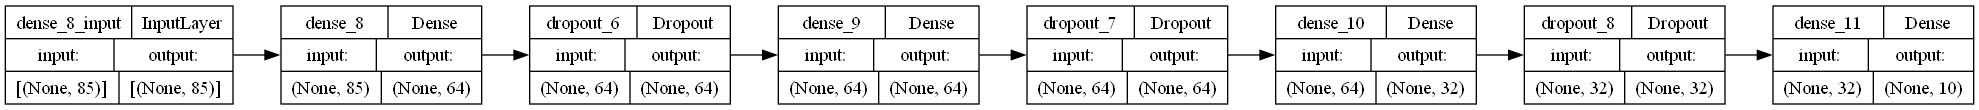

In [82]:
plot_model(dnn_poker_hand, show_shapes=True, show_layer_names=True, rankdir='LR')

## 7.3. Model compile

In [83]:
dnn_poker_hand.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Optimizing model

In [84]:
if new_model:
    es = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    cp = ModelCheckpoint(filepath='models/best_poker_model.weights.h5',
                         save_weights_only=True,
                         monitor='loss',
                         mode='min',
                         save_best_only=True, )

    history = dnn_poker_hand.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=128,
        callbacks=[cp, es],
        verbose=1
    )
    np.save('models/history_model.npy', history.history)
    dnn_poker_hand.load_weights('models/best_poker_model.weights.h5')
    dnn_poker_hand.save('models/best_poker_model.weights.h5')
else:
    dnn_poker_hand.load_weights('models/best_poker_model.weights.h5')

Epoch 1/100
137/137 [==============================] - 1s 3ms/step - loss: 1.2399 - accuracy: 0.4519 - val_loss: 1.0021 - val_accuracy: 0.4927
Epoch 2/100
137/137 [==============================] - 0s 2ms/step - loss: 1.0163 - accuracy: 0.4783 - val_loss: 1.0004 - val_accuracy: 0.4921
Epoch 3/100
137/137 [==============================] - 0s 2ms/step - loss: 1.0005 - accuracy: 0.4886 - val_loss: 0.9939 - val_accuracy: 0.4948
Epoch 4/100
137/137 [==============================] - 0s 2ms/step - loss: 0.9911 - accuracy: 0.5032 - val_loss: 0.9911 - val_accuracy: 0.4977
Epoch 5/100
137/137 [==============================] - 0s 3ms/step - loss: 0.9814 - accuracy: 0.5128 - val_loss: 0.9839 - val_accuracy: 0.5153
Epoch 6/100
137/137 [==============================] - 0s 2ms/step - loss: 0.9682 - accuracy: 0.5337 - val_loss: 0.9633 - val_accuracy: 0.5444
Epoch 7/100
137/137 [==============================] - 0s 3ms/step - loss: 0.9356 - accuracy: 0.5711 - val_loss: 0.9171 - val_accuracy: 0.5996

In [85]:
pygame.mixer.init()
success_audio = 'support_files/mario_coin.mp3'
pygame.mixer.music.load(success_audio)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    continue

print('Success!')

Success!


# 9. Evaluating optimizing quality

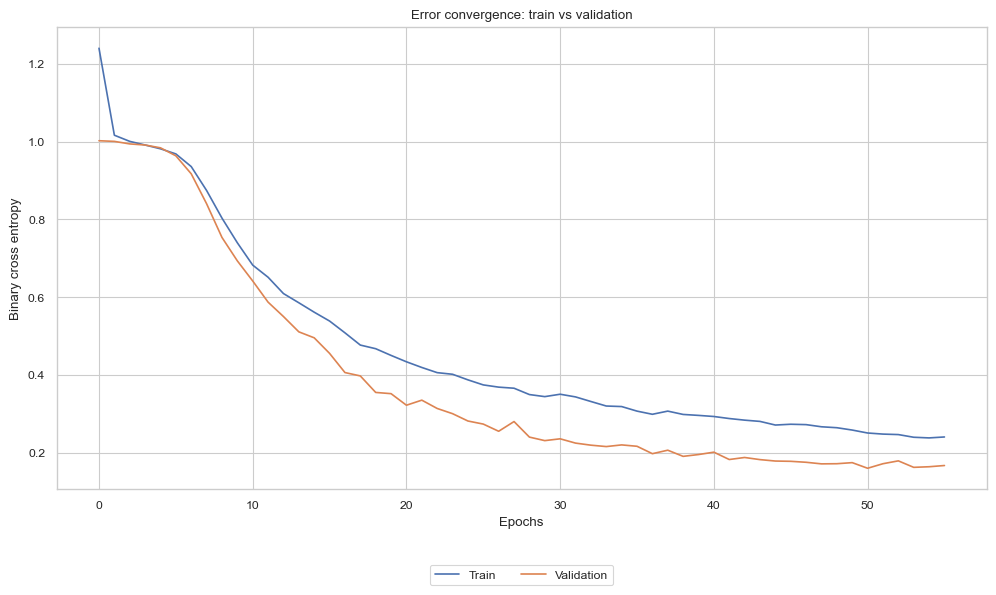

In [86]:
history = np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'Binary cross entropy'

fig = plt.figure()
plt.plot(train_metric, label='Train')
plt.plot(valid_metric, label='Validation')
plt.ylabel(name_metric)
plt.xlabel('Epochs')
plt.title('Error convergence: train vs validation')
plt.legend(loc='upper center', bbox_to_anchor = (0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()